In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [3]:
from rdkit import Chem
from rdkit.Chem import MACCSkeys #для получения фингерпринтов молекул
from rdkit.Chem import Descriptors, rdMolDescriptors, Fragments #для создания дескрипторов по smiles

In [31]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Чтение датасетов

датасеты были предобработанны способом написанном в файле `main.py`

In [6]:
df0 = pd.read_csv("oil_info_train.csv") #чтение предобработанного датасета
df0.smiles_list = df0.smiles_list.apply(eval) #конвертация строк списков в списки
df0.component_names_list = df0.component_names_list.apply(eval)
df0 = df0[~df0.val.apply(lambda x: x=="err")] #удаление значений в которых целевая переменная имеет ошибики (несколько значений для одного и того же blend_id)
df0.val = df0.val.apply(float) #преобразование строк чисел в числа

df0test = pd.read_csv("oil_info_test.csv")
df0test.smiles_list = df0test.smiles_list.apply(eval)
df0test.component_names_list = df0test.component_names_list.apply(eval)

In [7]:
df0.head(3)

,blend_id,oil_type,4c7a51f1-dc82-41dc-92fa-772535c2c70c,33fd9876-db06-478c-8993-17dd5d9d698a,val,7c8a81df-b7e7-4507-aab1-79a61fce7887,50d7e65f-df1c-4e73-8961-9608846cf1d3,7eef1eae-b625-40f0-bc54-9ee4eb2abeb3,049e5cb9-9c20-438c-9ef2-96870712a0be,76287f81-2806-481a-8dc6-7274a761e2f9,...,ca391f34-26e7-4427-a96e-326f560c36b2,b7cfc59a-c869-4aa3-b6dc-250db0c8fd33,96378e41-34be-4718-94cd-15bbf8276def,d733a865-4f57-476d-a850-32587a38ba91,64fc59c5-3d77-4dde-aef9-4bc4a8b39722,773bed06-8a5f-4f72-a9fd-89dac602ba20,6473371b-bbbc-4bc0-92da-b783da2a5277,132b1739-f7f7-4450-89b4-6d13fad0b6f2,smiles_list,component_names_list
0,49743a76-a614-11ee-9529-005056921581,3fa07e0a-415c-496d-b88b-557855cb3e77,15.58,-41.0,103300.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[CCCCC, CCCC(C)CCC, CCC(C(OC)=O)CC, CCCCC(C)C,...","[615537f6-1f8f-4240-a5e9-8f7be344ecd3, 6314fab..."
1,f320857e-dce9-11ed-803e-005056921581,3fa07e0a-415c-496d-b88b-557855cb3e77,15.40,-39.0,103100.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[CCCCC, CCCC(C)CCC, CCC(C(OC)=O)CC, CCCCC(C)C,...","[615537f6-1f8f-4240-a5e9-8f7be344ecd3, 6314fab..."
2,58e62d54-c6fc-11ed-863f-005056921581,60c1209c-8e77-467e-a01f-b6321801a260,16.55,-43.0,161250.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[CCCC(C)CCC, CCC(C(OC)=O)CC, CC(C)CCCCC]","[6314fabc-8e78-42be-87fb-948ba3bee8f9, a671588..."


# Подготовка фингерпринтов молекул

In [8]:
all_smiles = df0.smiles_list.sum() + df0test.smiles_list.sum() #все смайлсы встречающиеся в предоставленных смесях
unique_smiles, counts = np.unique(all_smiles, return_counts=True) #гистограмма по смайлсам

In [9]:
smiles_stat = pd.DataFrame({"smiles": unique_smiles, "count": counts}).sort_values(by="count", ascending=False)

### Генерирование фингерпринтов

In [10]:
temp = []
for smile in tqdm(smiles_stat.smiles):
    temp += [[smile,] + np.array(MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(smile))).tolist()]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 1253.92it/s]


In [11]:
smiles_fingerprints = pd.DataFrame(temp, columns = ["smiles"]+[f"key{i+1}" for i in range(len(temp[0])-1)])
smiles_fingerprints.head(9)

,smiles,key1,key2,key3,key4,key5,key6,key7,key8,key9,...,key158,key159,key160,key161,key162,key163,key164,key165,key166,key167
0,CCCC(C)CCC,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,CCC(C(OC)=O)CC,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,0,0,1,0,0
2,CCCCC(C)C,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,CCCCC,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,CCC(C)CCCC,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5,CC(C)CCCCC,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
6,CC(C)(C)CC(C)(C)C,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
7,CCC(C)(C)CC,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
8,CC(C(OCCCC)=O)C(OCCCC)=O,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,0,0,1,0,0


#### Очистка от нулевых фингерпринтов

In [12]:
null_keys = []
for i in range(1, 168):
    if(smiles_fingerprints[f"key{i}"].sum()==0):
        null_keys += [f"key{i}"]
print(f"Количество нулевых фич: {len(null_keys)}")

Количество нулевых фич: 51


In [13]:
smiles_fingerprints = smiles_fingerprints.drop(columns = null_keys)

In [14]:
smiles_fingerprints

,smiles,key9,key11,key12,key13,key19,key24,key30,key37,key40,...,key158,key159,key160,key161,key162,key163,key164,key165,key166,key167
0,CCCC(C)CCC,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,CCC(C(OC)=O)CC,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,0,0,1,0,0
2,CCCCC(C)C,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,CCCCC,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,CCC(C)CCCC,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,CC(C)(C)C(C)C(C)C,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
57,CCCCC(C)CCC(CC(C)C)C,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
58,CCC(CC(C)C)CC,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
59,O=C(OCCCCCCOC)NC1=CC=CC(NC(CCC)=O)=C1,0,0,0,0,0,1,0,0,0,...,1,1,1,1,1,1,1,1,1,0


# Подготовка датасетов

## Добавление свойств масла

выбраны два самых наиболее заполненных свойств для масел

In [15]:
needed_props = ['4c7a51f1-dc82-41dc-92fa-772535c2c70c', '33fd9876-db06-478c-8993-17dd5d9d698a']

In [17]:
df_train = df0[["blend_id",]+needed_props+["smiles_list", "val"]]
df_test = df0test[["blend_id",]+needed_props+["smiles_list",]]

пропущенные значения заменяем средними

In [18]:
for needed_prop in needed_props:
    df_train[needed_prop] = df_train[needed_prop].fillna(df_train[needed_prop].mean())
    df_test[needed_prop] = df_test[needed_prop].fillna(df_train[needed_prop].mean())

/tmp/ipykernel_171535/3265496066.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[needed_prop] = df_train[needed_prop].fillna(df_train[needed_prop].mean())
/tmp/ipykernel_171535/3265496066.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[needed_prop] = df_test[needed_prop].fillna(df_train[needed_prop].mean())


инвертируем отрицательные значения

In [20]:
df_train[needed_props[1]] = df_train[needed_props[1]].apply(lambda x: -x)
df_test[needed_props[1]] = df_test[needed_props[1]].apply(lambda x: -x)

/tmp/ipykernel_171535/904220682.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[needed_props[1]] = df_train[needed_props[1]].apply(lambda x: -x)
/tmp/ipykernel_171535/904220682.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[needed_props[1]] = df_test[needed_props[1]].apply(lambda x: -x)


In [21]:
df_train.head(3)

,blend_id,4c7a51f1-dc82-41dc-92fa-772535c2c70c,33fd9876-db06-478c-8993-17dd5d9d698a,smiles_list,val
0,49743a76-a614-11ee-9529-005056921581,15.58,41.0,"[CCCCC, CCCC(C)CCC, CCC(C(OC)=O)CC, CCCCC(C)C,...",103300.0
1,f320857e-dce9-11ed-803e-005056921581,15.40,39.0,"[CCCCC, CCCC(C)CCC, CCC(C(OC)=O)CC, CCCCC(C)C,...",103100.0
2,58e62d54-c6fc-11ed-863f-005056921581,16.55,43.0,"[CCCC(C)CCC, CCC(C(OC)=O)CC, CC(C)CCCCC]",161250.0


## Добавление фингерпринтов

Фингерпринт для смеси определяется как сумма фингерпринтов для всех входящих в смесь молекул

In [22]:
def get_fngprint_from_df(df_fngprints, smiles):
    '''функция нахождения фингерпринта в виде list по smiles в датафрейме df_fngprints'''
    return df_fngprints[df_fngprints.smiles == smiles].drop(columns = ["smiles"]).iloc[0].tolist()

def sum_of_fngprints(smiles):
    '''функция нахождения фингерпринта смеси (суммы фингерпринтов всех составляющих)'''
    s = np.zeros(167-51)
    for smile in smiles:
        # print(smile)
        s += np.array(get_fngprint_from_df(smiles_fingerprints, smile))
    return s

In [23]:
df_train = pd.concat([df_train, df_train.smiles_list.apply(sum_of_fngprints).apply(pd.Series)], axis=1)
df_test = pd.concat([df_test, df_test.smiles_list.apply(sum_of_fngprints).apply(pd.Series)], axis=1)

In [25]:
df_train.head(3)

,blend_id,4c7a51f1-dc82-41dc-92fa-772535c2c70c,33fd9876-db06-478c-8993-17dd5d9d698a,smiles_list,val,0,1,2,3,4,...,106,107,108,109,110,111,112,113,114,115
0,49743a76-a614-11ee-9529-005056921581,15.58,41.0,"[CCCCC, CCCC(C)CCC, CCC(C(OC)=O)CC, CCCCC(C)C,...",103300.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0
1,f320857e-dce9-11ed-803e-005056921581,15.40,39.0,"[CCCCC, CCCC(C)CCC, CCC(C(OC)=O)CC, CCCCC(C)C,...",103100.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0
2,58e62d54-c6fc-11ed-863f-005056921581,16.55,43.0,"[CCCC(C)CCC, CCC(C(OC)=O)CC, CC(C)CCCCC]",161250.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0


## Добавление дескрипторов

функции вычисления дескрипторов

In [26]:
# функции создания новых предикторов:

# 1. количество компонентов в смеси:
def n_mol(smiles):
  return len(smiles)

# 2. средний размер молекулы (количество атомов)
def n_atom_mean(smiles):
  N=0
  if len(smiles)!=0:
    for el in smiles:
      mol = Chem.MolFromSmiles(el)
      N+=mol.GetNumAtoms()
    N/=len(smiles)
  return N

# 3. Доля атомов С:
def frac_atom_с(smiles):
  N=0
  if len(smiles)!=0:
    for el in smiles:
      mol = Chem.MolFromSmiles(el)
      N+=sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() == 'C')
    N/=len(smiles)
  return N
# 4. Доля атомов O:
def frac_atom_o(smiles):
  N=0
  if len(smiles)!=0:
    for el in smiles:
      mol = Chem.MolFromSmiles(el)
      N+=sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() == 'O')
    N/=len(smiles)
  return N
# 5. Средний молекулярный вес:
def mol_w_mean(smiles):
  w=0
  if len(smiles)!=0:
    for el in smiles:
      mol = Chem.MolFromSmiles(el)
      w+=Descriptors.ExactMolWt(mol)
    w/=len(smiles)
  return w
# 6. Среднее значение логарифма коэффициента распределения:
def MolLogP_mean(smiles):
  m=0
  if len(smiles)!=0:
    for el in smiles:
      mol = Chem.MolFromSmiles(el)
      m+=Descriptors.MolLogP(mol)
    m/=len(smiles)
  return m
# 7. Общая полярная поверхность: сумма полярных поверхностей всех компонентов:
def TPSA_sum(smiles):
  TPSA=0
  if len(smiles)!=0:
    for el in smiles:
      mol = Chem.MolFromSmiles(el)
      TPSA+=Descriptors.TPSA(mol)
  return TPSA
# 8. Cреднее количество связей:
def n_bonds_mean(smiles):
  n=0
  if len(smiles)!=0:
    for el in smiles:
      mol = Chem.MolFromSmiles(el)
      n+=mol.GetNumBonds()
    n/=len(smiles)
  return n
# 9. Средняя степень насыщенности:
def n_bonds_nn_mean(smiles):
  n=0
  if len(smiles)!=0:
    for el in smiles:
      mol = Chem.MolFromSmiles(el)
      n+=sum(1 for bond in mol.GetBonds() if bond.GetBondType() == Chem.rdchem.BondType.DOUBLE)
      n+=sum(1 for bond in mol.GetBonds() if bond.GetBondType() == Chem.rdchem.BondType.TRIPLE)
    n/=len(smiles)
  return n
# 10. Общее количество колец:
def n_col(smiles):
  n=0
  if len(smiles)!=0:
    for el in smiles:
      mol = Chem.MolFromSmiles(el)
      n+=mol.GetRingInfo().NumRings()
    n/=len(smiles)
  return n
# 11. Средние топологические индексы (Винера):
def ind_V_mean(smiles):
  i=0
  if len(smiles)!=0:
    for el in smiles:
      mol = Chem.MolFromSmiles(el)
      distance_matrix = Chem.rdmolops.GetDistanceMatrix(mol)
      i+=0.5*sum(sum(distance_matrix[i, j] for j in range(i + 1, mol.GetNumAtoms())) for i in range(mol.GetNumAtoms()))
    i/=len(smiles)
  return i
# 12. Площадь доступной поверхности, вычисленная по методу Лабута (гидрофобность):
def LabuteASA(smiles):
  n=0
  if len(smiles)!=0:
    for el in smiles:
      mol = Chem.MolFromSmiles(el)
      n+=Descriptors.LabuteASA(mol)
  return n
# 13. Доп:
def HallKierAlpha(smiles):
  n=0
  if len(smiles)!=0:
    for el in smiles:
      mol = Chem.MolFromSmiles(el)
      n+=Descriptors.HallKierAlpha(mol)
    n/=len(smiles)
  return n

In [28]:
df_train['n_mol']=df_train['smiles_list'].apply(n_mol)
df_train['n_atom_mean']=df_train['smiles_list'].apply(n_atom_mean)
df_train['frac_atom_с']=df_train['smiles_list'].apply(frac_atom_с)
df_train['frac_atom_o']=df_train['smiles_list'].apply(frac_atom_o)
df_train['mol_w_mean']=df_train['smiles_list'].apply(mol_w_mean)
df_train['MolLogP_mean']=df_train['smiles_list'].apply(MolLogP_mean)
df_train['TPSA_sum']=df_train['smiles_list'].apply(TPSA_sum)
df_train['n_bonds_mean']=df_train['smiles_list'].apply(n_bonds_mean)
df_train['n_bonds_nn_mean']=df_train['smiles_list'].apply(n_bonds_nn_mean)
df_train['n_col']=df_train['smiles_list'].apply(n_col)
df_train['ind_V_mean']=df_train['smiles_list'].apply(ind_V_mean)
df_train['LabuteASA']=df_train['smiles_list'].apply(LabuteASA)
df_train['HallKierAlpha']=df_train['smiles_list'].apply(HallKierAlpha)

df_train.columns = [str(col) for col in df_train.columns] #смена типа имени колонок на строки

In [29]:
df_test['n_mol']=df_test['smiles_list'].apply(n_mol)
df_test['n_atom_mean']=df_test['smiles_list'].apply(n_atom_mean)
df_test['frac_atom_с']=df_test['smiles_list'].apply(frac_atom_с)
df_test['frac_atom_o']=df_test['smiles_list'].apply(frac_atom_o)
df_test['mol_w_mean']=df_test['smiles_list'].apply(mol_w_mean)
df_test['MolLogP_mean']=df_test['smiles_list'].apply(MolLogP_mean)
df_test['TPSA_sum']=df_test['smiles_list'].apply(TPSA_sum)
df_test['n_bonds_mean']=df_test['smiles_list'].apply(n_bonds_mean)
df_test['n_bonds_nn_mean']=df_test['smiles_list'].apply(n_bonds_nn_mean)
df_test['n_col']=df_test['smiles_list'].apply(n_col)
df_test['ind_V_mean']=df_test['smiles_list'].apply(ind_V_mean)
df_test['LabuteASA']=df_test['smiles_list'].apply(LabuteASA)
df_test['HallKierAlpha']=df_test['smiles_list'].apply(HallKierAlpha)

df_test.columns = [str(col) for col in df_test.columns] #смена типа имени колонок на строки

In [62]:
df_train.head()

,blend_id,4c7a51f1-dc82-41dc-92fa-772535c2c70c,33fd9876-db06-478c-8993-17dd5d9d698a,smiles_list,val,0,1,2,3,4,...,frac_atom_o,mol_w_mean,MolLogP_mean,TPSA_sum,n_bonds_mean,n_bonds_nn_mean,n_col,ind_V_mean,LabuteASA,HallKierAlpha
0,49743a76-a614-11ee-9529-005056921581,15.58,41.0,"[CCCCC, CCCC(C)CCC, CCC(C(OC)=O)CC, CCCCC(C)C,...",103300.0,0.0,0.0,0.0,0.0,0.0,...,0.400000,108.923166,2.663220,26.30,6.600000,0.200000,0.0,32.900000,250.284528,-0.106000
1,f320857e-dce9-11ed-803e-005056921581,15.40,39.0,"[CCCCC, CCCC(C)CCC, CCC(C(OC)=O)CC, CCCCC(C)C,...",103100.0,0.0,0.0,0.0,0.0,0.0,...,0.333333,109.792780,2.756467,26.30,6.666667,0.166667,0.0,34.000000,303.578374,-0.088333
2,58e62d54-c6fc-11ed-863f-005056921581,16.55,43.0,"[CCCC(C)CCC, CCC(C(OC)=O)CC, CC(C)CCCCC]",161250.0,0.0,0.0,0.0,0.0,0.0,...,0.666667,119.460360,2.680333,26.30,7.333333,0.333333,0.0,41.333333,162.791663,-0.176667
3,0366a302-d9cd-11ed-96ad-005056921581,7.09,58.0,"[CC(OCCCCOC)=O, CC(C(OCCCC)=O)C(OCCCC)=O, CCCC...",6806.0,0.0,0.0,0.0,0.0,0.0,...,2.333333,242.884335,4.283800,88.13,16.000000,1.000000,0.0,433.166667,320.119127,-0.543333
4,388fac92-e18d-11ec-8487-005056921581,15.53,44.0,"[CCC(C)CCCC, CCCCC, CCCC(C)CCC, CCC(C(OC)=O)CC...",116600.0,0.0,0.0,0.0,0.0,0.0,...,0.333333,107.456839,2.715467,26.30,6.500000,0.166667,0.0,33.000000,297.213432,-0.088333


# Обучение

In [63]:
df_train = df_train[df_train.val > 0]

In [64]:
scaler = MinMaxScaler()
y = scaler.fit_transform(df_train["val"].apply(np.log10).to_numpy().reshape(-1, 1))

## Только на дескрипторах

In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    df_train.drop(columns = ["val", "smiles_list", "blend_id"] + needed_props + [f"{i}" for i in range(116)]), y,
    random_state = 8864
)

In [66]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
mean_absolute_error(10**scaler.inverse_transform(rfr.predict(X_test).reshape(-1, 1)), 10**scaler.inverse_transform(y_test))

/home/oleg/Документы/pythontest/хакатон/file-2 2/venv/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


27752.669126453628

## Только на фингерпринтах

In [67]:
X_train, X_test, y_train, y_test = train_test_split(
    df_train[[f"{i}" for i in range(116)]], y,
    random_state = 8864
)

In [68]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
mean_absolute_error(10**scaler.inverse_transform(rfr.predict(X_test).reshape(-1, 1)), 10**scaler.inverse_transform(y_test))

/home/oleg/Документы/pythontest/хакатон/file-2 2/venv/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


22497.023988733148

## Объединённая таблица (фингерпринты + дескрипторы + свойства масла)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(
    df_train.drop(columns = ["val", "smiles_list", "blend_id"]), y,
    random_state = 8864
)

In [70]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
mean_absolute_error(10**scaler.inverse_transform(rfr.predict(X_test).reshape(-1, 1)), 10**scaler.inverse_transform(y_test))

/home/oleg/Документы/pythontest/хакатон/file-2 2/venv/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


13607.884270822175

## Только по свойствам масла

In [49]:
X_train, X_test, y_train, y_test = train_test_split(
    df_train[needed_props], y,
    random_state = 8864
)

In [50]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
mean_absolute_error(10**scaler.inverse_transform(rfr.predict(X_test).reshape(-1, 1)), 10**scaler.inverse_transform(y_test))

/home/oleg/Документы/pythontest/хакатон/file-2 2/venv/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


24276.938750037123

In [51]:
import seaborn as sns

In [53]:
import matplotlib.pyplot as plt

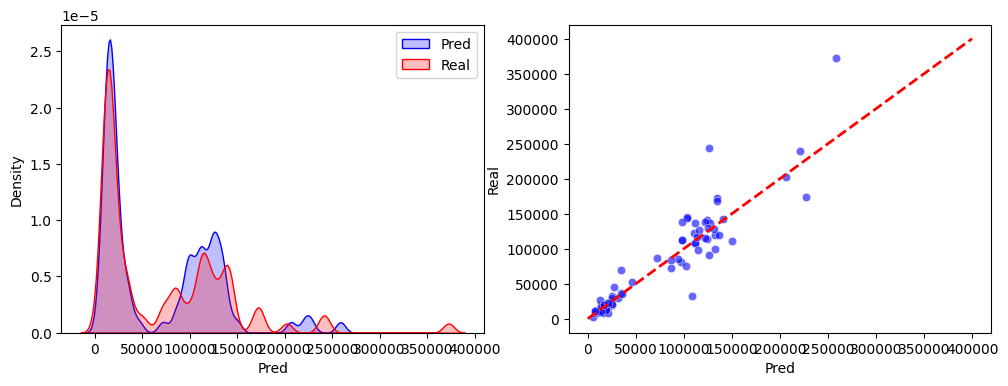

In [80]:
def plot_res(pred, y_test):
  fig, ax = plt.subplots(1,2, figsize=(12,4))
  pred_df = pd.DataFrame({'Pred': pred, 'Real': y_test})
  sns.kdeplot(ax=ax[0], data=pred_df, x='Pred', fill=True, bw_adjust=0.2, label='Pred', color='blue')
  sns.kdeplot(ax=ax[0], data=pred_df, x='Real', fill=True, bw_adjust=0.2, label='Real', color='red')
  ax[0].legend()
  sns.scatterplot(ax=ax[1], data=pred_df, x="Pred", y="Real", color='blue', alpha=0.6)
  plt.plot([0, 400000], [0, 400000], color='red', lw=2, linestyle='--')

plot_res(10**scaler.inverse_transform(rfr.predict(X_test).reshape(-1, 1)).reshape(1, -1)[0], 10**scaler.inverse_transform(y_test).reshape(1, -1)[0])

/tmp/ipykernel_171535/173581272.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Дескрипторы", "Свойства масла", "Фингерпринты", "Деск+Св+Финг"], y=[26352.63743213892, 24276.938750037123, 22515.824034891135, 13531.54282483255], palette="coolwarm")


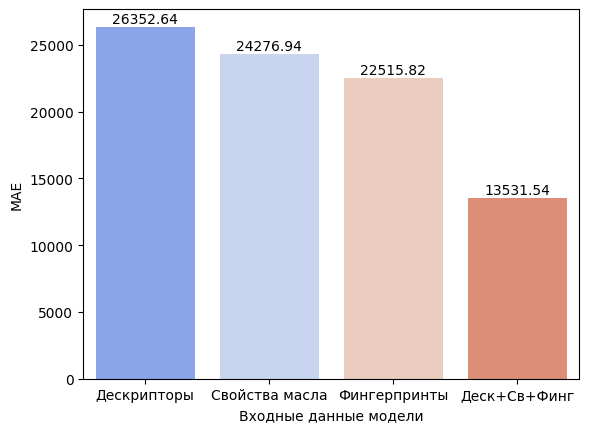

In [86]:
values = [26352.63743213892, 24276.938750037123, 22515.824034891135, 13531.54282483255]
sns.barplot(x=["Дескрипторы", "Свойства масла", "Фингерпринты", "Деск+Св+Финг"], y=[26352.63743213892, 24276.938750037123, 22515.824034891135, 13531.54282483255], palette="coolwarm")
plt.gca().set_xlabel("Входные данные модели") 
plt.gca().set_ylabel("MAE")
for i, v in enumerate(values): 
    plt.gca().text(i, v + 300, round(v, 2), color='black', ha='center', fontsize=10)
